# Text generation with deep learning

In [1]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets
from torch.nn.utils.rnn import pad_sequence


%matplotlib inline

from torch.utils.data import DataLoader
import pickle

# для визуализации
# from bokeh.io import show,output_notebook
# from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
# from bokeh.models import FuncTickFormatter
# from bokeh.plotting import figure

# output_notebook()

C:\Users\User\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

# Считывание данных

In [41]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# arxiv_dataset = pd.read_csv('/content/drive/MyDrive/Универ/arxiv.csv') 
arxiv_dataset = pd.read_csv('arxiv.csv') 
arxiv_dataset

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0
...,...,...,...,...,...,...,...,...,...,...
27183,arxiv.org/abs/1710.04176,NaN,NaN,NaN,"[C. -C. Jay Kuo, Yueru Chen]",cs.CV,2017-10-11 17:08:28,Being motivated by the multilayer RECOS (REcti...,On Data-Driven Saak Transform,0
27184,arxiv.org/abs/1710.04177,NaN,NaN,NaN,"[Heather Mattie, Kenth Engø-Monsen, Rich Ling,...",cs.SI,2017-10-11 17:12:05,"Understanding tie strength in social networks,...",The Social Bow Tie,0
27185,arxiv.org/abs/1710.04196,NaN,NaN,NaN,"[Robin Scheibler, Eric Bezzam, Ivan Dokmanić]",cs.MS,2017-10-11 17:44:41,"We present pyroomacoustics, a software package...",Pyroomacoustics: A Python package for audio ro...,0
27186,arxiv.org/abs/1710.04200,NaN,NaN,NaN,"[Yijun Li, Jia-Bin Huang, Narendra Ahuja, Ming...",cs.CV,2017-10-11 17:56:59,Joint image filters leverage the guidance imag...,Joint Image Filtering with Deep Convolutional ...,0


In [3]:
class TextDataset(Dataset):
    def __init__(self, text, input_dict=None, chunk_len=10, chunks_number=100, device = torch.device("cuda")):
        self.chunks_number = chunks_number # количество блоков
        self.chunk_len = chunk_len  # длина одного блока (на сколько букв смотрим назад при предсказании)
        self.text = text
        self.device = device
        if input_dict == None:
            self.all_symbols = list({x for x in self.text})
        else:
            self.all_symbols = input_dict
    
    def __len__(self): # возвращает число чанков (случайных слайсов по тексту?)
        return self.chunks_number
    
    def _get_tensor(self, text):   # ставит в соответствие каждой букве из текста её индекс
        return torch.LongTensor(list(map(self.all_symbols.index, text))).to(self.device)
    
    def _decode_vector(self, text):   # декодирует вектор из цифр (text) в текст
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):  # берет случайный срез букв из текста
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
#         print("==========================================")
        chunk = self._get_random_slice()
#         print("text:", self.text)
#         print("chunk:", chunk)
#         print("symbols:")
#         for symb in self.all_symbols:
#             print(self._get_tensor(symb), symb)
        # self._get_tensor(chunk[:-1]) - текущее состояние, self._get_tensor(chunk[1:]) - следующее состояние (target)
        if len(chunk) == self.chunk_len + 1: # стандартное поведение
#             print("check passed, return:", self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:]))
            return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])  # chunk[:-1] не включает последний эл-т, chunk[1:] не включает первый эл-т
        else: # попали на последний символ
            return torch.LongTensor([self.all_symbols.index(char) for char in chunk]).to(self.device), torch.LongTensor([self.all_symbols.index(char) for char in chunk[1:]] + [97]).to(self.device)

In [4]:
# Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети
symbols = []
for i in range(len(arxiv_dataset['summary'])):
    Text_Dataset = TextDataset(arxiv_dataset['summary'][i])
    for symbol in Text_Dataset.all_symbols:
        if symbol not in symbols:
            symbols.append(symbol)
symbols.append('')
print(len(symbols))

98


## Параметры

In [221]:
unique_symbols = len(symbols) # число уникальных символов во всём датасете
n_layers = 2 # число слоёв для hidden
hidden_size = 100 # размер скрытого слоя
epochs = 10 # число эпох
chunk_len = 10 # размер чанка (слайса из одного summary)
batch_size = 2 # размер батча
device = torch.device("cuda") # на каком девайсе будет вычисление

## Dataloader

In [149]:
def collate_fn(input_data, device=torch.device("cuda")):  # на вход приходит arxiv_dataset['summary'][:batch_size]
#     len(input_data) == число батчей
#     len(item_.all_symbols) == число уникальных символов/размер словаря/размер one-hot вектора

#     input_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).int().to(device)
#     target_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).to(device)

    input_tensor = torch.zeros(len(input_data), chunk_len, 1).int().to(device)
    target_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).to(device)
    
    for batch_id, item in enumerate(input_data):
#         for chunks_n in range(item_.chunks_number):
#             inputs.append(item_.__getitem__(chunks_n)[0])
#             targets.append(item_.__getitem__(chunks_n)[1])
        # torch.zeros(len(line), 1, n_letters)
        
        item_ = TextDataset(item, symbols)
        line = item_.__getitem__(0)
#         for li in range(item_.chunk_len):
#             letter = line[li]
#             input_tensor[li][0][item_.all_symbols.index(letter)] = 1
#         for li in range(item_.chunk_len):
#             input_tensor[li][0][line[0][li]] = 1
#             target_tensor[li][0][line[1][li]] = 1

#         for li in range(item_.chunk_len): # цикл для вложенности 2
#             input_tensor[line[0][li]] = 1
#             target_tensor[line[1][li]] = 1

#         for i in range(item_.chunk_len):
#             for j in range(i + 1):
#                 input_tensor[batch_id][i][line[0][j]] = 1
#             target_tensor[batch_id][i][line[1][i]] = 1

        for i in range(item_.chunk_len):
            input_tensor[batch_id][i][0] = line[0][i]
            target_tensor[batch_id][i][line[1][i]] = 1

#     return {'inputs': inputs.to(device), 'targets': targets.to(device)}
    return {'inputs': input_tensor, 'targets': target_tensor}

In [184]:
# collate_fn test
# btc = collate_fn(arxiv_dataset['summary'][:2])
# btc

In [25]:
# slice test
# btc['inputs'][:,2] 

tensor([[15],
        [27]], device='cuda:0', dtype=torch.int32)

## Определим структуру сети, в качестве основного блока используем **GRU**

In [34]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, n_layers=1):
#         super(RNN, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers
        
#         self.encoder = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
#         self.decoder = nn.Linear(hidden_size, output_size)
    
#     def forward(self, input, hidden):
#         input = self.encoder(input.view(1, -1))
#         output, hidden = self.gru(input.view(1, 1, -1), hidden)
#         output = self.decoder(output.view(1, -1))
#         return output, hidden

#     def init_hidden(self):
#         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
#     def save_model(model, filename='rnn.ckpt'):
#         checkpoint = {'input_size': model.input_size,
#                       'hidden_size': model.hidden_size,
#                       'output_size': model.output_size,
#                       'n_layers': model.n_layers,
#                       'state_dict': model.state_dict()}
#         with open(filename, 'wb') as f:
#             torch.save(checkpoint, f)

#     def load_model(filename):

#         with open(filename, 'rb') as f:
#             checkpoint = torch.load(f)

#         model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
#         model.load_state_dict(checkpoint['state_dict'])

#         return model

In [153]:
class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, batch_size, n_layers=1):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
#         self.batch_size = batch_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # input_size (==unique_symbols) – size of the dictionary of embeddings
        # hidden_size – the size of each embedding vector
        # Вход: (*) IntTensor или LongTensor произвольной формы, содержащие индексы для извлечения
        # Output: (∗, H), where * is the input shape and H = hidden_size
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
        # inputs.shape[0] == batch_size
        #print("input before encoding: ", inputs, "shape:", inputs.shape)
#         print("================================================")
        inputs = self.encoder(inputs.view(inputs.shape[0], -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size
        
        #print("inputs after encoding: ", inputs, "shape:", inputs.shape)
#         print("input shape after encoding: ", input.shape)
#         print("================================================")
#         print("inputs.view(1, 1, -1): ", inputs.view(1, 1, -1), "shape=", inputs.view(1, 1, -1).shape)
#         print("inputs.view(1, -1): ", inputs.view(1, -1), "shape=", inputs.view(1, -1).shape)
#         print("inputs.view(1, batch_size, -1): ", inputs.view(1, self.batch_size, -1), "shape=", inputs.view(1, self.batch_size, -1).shape)
#         print("================================================")
#         print("hidden: ", hidden, "shape=", hidden.shape)

        # складываем эмбединги
#         inputs_sum = torch.zeros(self.batch_size, self.hidden_size).to(device)
#         for i in range(self.batch_size):
#             inputs_sum[i] = inputs[i].sum(0)

        output, hidden = self.gru(inputs.view(1, inputs.shape[0], -1), hidden)
        output = self.decoder(output.view(inputs.shape[0], -1))
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

In [155]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)

net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)

## Цикл обучения

In [219]:
def training(net, epochs, optimizer, criterion, loader, device, batch_size):
    start = time.time()
    
    losses_avg = []
    losses_best = []
    net.train()

    for epoch in range(1, epochs+1):
        print('epoch: ', epoch)
        losses = []
        hidden = net.init_hidden(batch_size).to(device)
        
        for i, batch in enumerate(tqdm(loader)): # for inputs, targets in loader:
            loss = 0
            hidden = hidden.detach()
            optimizer.zero_grad()

            for chars in range(len(batch["inputs"][0])): # len(batch["inputs"][0]) == chunk_len
                # len(batch) == 2 ("inputs", "targets")
                # len(batch["inputs"]) == len(batch["targets"]) == batch_size
                # len(batch["inputs"][i]) == len(batch["targets"][i]) == chunk_len, i от 0 до batch_size
                # len(batch["inputs"][i][j]) == len(batch["targets"][i][j]) == unique_symbols (число уникальных символов)

                output, hidden = net(batch['inputs'][:,chars], hidden)

    #             output_max = torch.LongTensor(batch_size, 1)
    #             for i in range(len(output)): # по всем батчам
    #                 output_max[i] = output[i].argmax()

    #             print(output)
    #             print(batch['targets'][:,chars]) # tensor размера batch_size x 98 (из 97 нулей и 1 единицы)

                loss += criterion(output, batch['targets'][:,chars])

            loss = loss / len(batch["inputs"][0])

            loss.backward()
            optimizer.step()

            loss = loss.cpu().detach().numpy()

            # print("loss: ", loss)
            losses.append(loss)

        # print('losses: ', losses)
        losses_avg.append(np.mean(losses))
        # print(np.mean(losses))
        # print(losses[0], np.mean(losses))
        losses_best.append(sorted(losses, reverse=False)[0])  # reverse=False - в порядке возрастания

        if epoch%10 == 0:
            print("Saving...")
    #         RNN.save_model(net, f'/content/drive/MyDrive/Универ/TrainedModel_epoch_{epoch}.ckpt')
            RNN.save_model(net, f'TrainedModel_epoch_{epoch}.ckpt')
    print("Training finished, time:", time.time() - start)
    return losses_avg, losses_best, net, hidden

In [222]:
loader = DataLoader(arxiv_dataset['summary'], 
                    batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                    shuffle=True, # перетасовка данных между эпохами
#                             num_workers=2,
                    collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                    drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                    )

l_avg, l_best, net, hidden = training(net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers).to(device),
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = torch.device("cuda"),
                                     batch_size=batch_size)

epoch:  1


  3%|██▎                                                                           | 413/13594 [00:11<06:21, 34.54it/s]


KeyboardInterrupt: 

## Генерация текста с помощью сети

In [200]:
def generate(net, device, dataset, prime_str="A bob", predict_len=100, temperature=0.8):
    with torch.no_grad():
        net.eval()
        predicted_string = prime_str
        hidden = net.init_hidden(1).to(device)
#         input_char = torch.LongTensor([dataset.all_symbols.index(prime_str)]).cuda()
        input_char = dataset._get_tensor(prime_str[-1])

        while len(predicted_string) < predict_len:

            output, hidden = net(input_char, hidden) # генерируем продолжение строки и новый hidden
            
            probability = torch.softmax(output / temperature, dim=1)
#             print(probability)
       
            next_char = random.choices(dataset.all_symbols, weights=probability[0])[0]
            
#             id_of_next_char = output.argmax() # ищем номер самой вероятной буквы для продолжения
            
#             if id_of_next_char == len(dataset.all_symbols) - 1:
            if next_char == "":
                break
#             next_char = dataset.all_symbols[id_of_next_char]
            predicted_string += next_char
            
#             input_char = torch.LongTensor([dataset.all_symbols.index(next_char)]).cuda()
            input_char = dataset._get_tensor(next_char)
            
        return predicted_string

In [201]:
text_dataset = TextDataset("aboba", symbols, chunk_len=10)

## Результаты тренировки

In [206]:
generate(net, device, text_dataset)

'A bob&g|hp{tqc!Wy:36b(L*)}[qh\nP'

In [217]:
# print(generate(net, device, arxiv_dataset, 'In this research', 200 ), '\n')
print(generate(net, device, text_dataset, 'In this research', 200, .8), '\n')

In this researchG#Cq`;#P:n:A__8/Bc 



# Тестирование

In [19]:
inputs = torch.LongTensor([symbols.index("A")]).cuda()
net(inputs, hidden.cuda())[0].shape

torch.Size([1, 98])

In [22]:
pred = net(inputs, hidden.cuda())[0]

In [35]:
pred

tensor([[ -3.4287,   0.7673,  -5.5772,  -3.6050,  -4.0858,  -1.0775,  -5.9385,
          -4.6353,  -0.4473,   0.0648,  -5.2527,  -1.7242,  -2.6784,   0.6840,
          -4.4650,  -6.1217,  -7.1478,   0.2174,  -6.0777,  -6.3620,  -4.9229,
           0.1024,  -2.6279,  -1.6673,  -6.2317,  -1.9567,  -6.0442,  -7.3561,
          -2.5173,  -1.0740,   1.1548,  -4.7866,  -6.2299,   1.2050,  -2.9068,
          -0.7309,  -5.8618,  -4.2097,  -6.0112,  -6.4307,  -7.0132,  -5.7819,
          -5.6711,  -9.1844,  -6.2927,  -6.7617,  -9.0003,  -8.6777,  -6.7467,
          -6.3367,  -6.8252,  -6.2397,  -7.1575,  -6.9217,  -8.6735,  -6.7276,
         -10.1495,  -6.1476,  -8.1759,  -7.1865,  -5.5879,  -7.0190, -11.7084,
         -11.9192,  -6.7862, -10.6048,  -9.3374, -10.3494, -11.4785, -10.4546,
          -7.1347,  -8.8615,  -8.0262, -11.4216, -15.7779,  -8.6676, -14.3619,
         -12.7619, -10.3936, -14.1475, -13.5221, -12.7191, -10.2625, -11.6673,
         -15.2373, -14.1318, -16.4665, -12.6955, -15

In [33]:
pred.argmax()

tensor(33, device='cuda:0')

In [36]:
symbols[pred.argmax()]

'M'

# Здесь должны быть эксперименты с архитектурой и параметрами сети

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size) # получает 1 чар в one-hot представлении, то есть вектор из 98 элементов и превращает его в вектор размера 100
        
        # input_size (==unique_symbols) – size of the dictionary of embeddings
        # hidden_size – the size of each embedding vector
        # Вход: (*) IntTensor или LongTensor произвольной формы, содержащие индексы для извлечения
        # Output: (∗, H), where * is the input shape and H = hidden_size
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
        #print("input before encoding: ", inputs, "shape:", inputs.shape)
#         print("================================================")
        inputs = self.encoder(inputs.view(self.batch_size, -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size
        
        #print("inputs after encoding: ", inputs, "shape:", inputs.shape)
#         print("input shape after encoding: ", input.shape)
#         print("================================================")
#         print("inputs.view(1, 1, -1): ", inputs.view(1, 1, -1), "shape=", inputs.view(1, 1, -1).shape)
#         print("inputs.view(1, -1): ", inputs.view(1, -1), "shape=", inputs.view(1, -1).shape)
#         print("inputs.view(1, batch_size, -1): ", inputs.view(1, self.batch_size, -1), "shape=", inputs.view(1, self.batch_size, -1).shape)
#         print("================================================")
#         print("hidden: ", hidden, "shape=", hidden.shape)

        # складываем эмбединги
        inputs_sum = torch.zeros(self.batch_size, self.hidden_size).to(device)
        for i in range(self.batch_size):
            inputs_sum[i] = inputs[i].sum(0)
    
        output, hidden = self.gru(inputs_sum.view(1, self.batch_size, -1), hidden)
#         print("gru passed")
        output = self.decoder(output.view(self.batch_size, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, self.batch_size, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

In [111]:
# input_size = 98 # torch.Size([2, 98, 100])
# input_size = 2 # torch.Size([2, 98, 100])
# input_size = 1 # ошибка

btc = collate_fn(arxiv_dataset["summary"][:2]) # берём батч размера batch_size=2

input_size = 98 # == число уникальных символов в датасете
hidden_size = 100
batch_size = 2
encoderrrr = nn.Embedding(input_size, hidden_size)
linearrrr = nn.Linear(input_size, hidden_size)
for chars in range(1): # для примера, берём только одну, первую букву
    inputs = btc['inputs'][:,chars].cpu()
    print("inputs:", inputs) # 
    print("inputs shape:", inputs.shape)
    
    print("================embedding==================")
#     print("inputs[0]:\n", inputs[0])
#     print("inputs.view(batch_size, -1):\n", inputs.view(batch_size, -1))
    encoded = encoderrrr(inputs.view(batch_size,-1)) # преобразовывается каждый элемент one-hot вектора в вектор hidden для всех батчей (2x98-->2x98x100)
#     encoded = encoderrrr(inputs)
    print("inputs after encoder:", encoded)
    print("inputs shape after encoder:", encoded.shape)
    
    print("================summ==================")
    summed = torch.zeros(len(inputs), 100)
    for mini_batch in range(len(inputs)):
#         encoded[mini_batch] = encoded[mini_batch].sum(0)
#         print("inputs after encoder sum:", encoded[mini_batch].sum(0))
        summed[mini_batch] = encoded[mini_batch].sum(0)
    print("inputs after encoder sum:", summed)
    print("inputs shape after encoder sum:", summed.shape)
    
    print("================linear:==================")
    lineared = linearrrr(inputs.float()) # преобразовываем one-hot вектор в вектор hidden для всех батчей (2x98-->2x100)
    print("inputs after linear:", lineared)
    print("inputs shapes after linear:",lineared.shape)

inputs: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], dtype=torch.int32)
inputs shape: torch.Size([2, 98])
================embedding==================
inputs after encoder: tensor([[[ 0.4356, -0.9803, -1.2567,  ...,  0.1187, -0.9767, -0.4646],
         [ 0.4356, -0.9803, -1.2567,  ...,  0.1187, -0.9767, -0.4646],
         [ 0.4356, -0.9803, -1.2567,  ...,  0.1187

In [28]:
net = RNN(unique_symbols, hidden_size, unique_symbols, batch_size, n_layers)

net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

In [29]:
def collate_fn(input_data, device=torch.device("cuda")):  # на вход приходит arxiv_dataset['summary']
#     len(input_data) == число батчей
#     len(item_.all_symbols) == число уникальных символов/размер словаря/размер one-hot вектора

    input_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).int().to(device)
    target_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).to(device)
    
    for batch_id, item in enumerate(input_data):
#         for chunks_n in range(item_.chunks_number):
#             inputs.append(item_.__getitem__(chunks_n)[0])
#             targets.append(item_.__getitem__(chunks_n)[1])
        # torch.zeros(len(line), 1, n_letters)
        
        item_ = TextDataset(item, symbols)
        line = item_.__getitem__(0)
        
#         input_tensor = torch.zeros(item_.chunk_len, 1, len(item_.all_symbols)).int()
#         target_tensor = torch.zeros(item_.chunk_len, 1, len(item_.all_symbols)).int()
       
#         input_tensor = torch.zeros(len(item_.all_symbols)).int() # тензор вложенности 1 (длина 98)
#         target_tensor = torch.zeros(len(item_.all_symbols)).int()

#         input_tensor = torch.zeros(len(input_data), item_.chunk_len, len(item_.all_symbols)).int().to(device)
#         target_tensor = torch.zeros(len(input_data), item_.chunk_len, len(item_.all_symbols)).int().to(device)
    
#         for li in range(item_.chunk_len):
#             letter = line[li]
#             input_tensor[li][0][item_.all_symbols.index(letter)] = 1
#         for li in range(item_.chunk_len):
#             input_tensor[li][0][line[0][li]] = 1
#             target_tensor[li][0][line[1][li]] = 1

#         for li in range(item_.chunk_len): # цикл для вложенности 2
#             input_tensor[line[0][li]] = 1
#             target_tensor[line[1][li]] = 1

        for i in range(item_.chunk_len):
            for j in range(i + 1):
                input_tensor[batch_id][i][line[0][j]] = 1
            target_tensor[batch_id][i][line[1][i]] = 1
            
#         inputs.append(input_tensor) #
#         targets.append(target_tensor)
        
#         inputs.append(item_[0])
#         targets.append(item_[1])
#     print("collate_fn before pad:", inputs, targets)

#     inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
#     targets = pad_sequence(targets, batch_first=True, padding_value=0)
    
    # pad_sequence - возвращает Tensor размерности T x B x * or B x T x * (если batch_first=True)
    # B это batch size. (Он равен количеству элементов в sequence)
    # T длина наибольшей sequence. 
    # L длина sequence. 
    #* любое кол-во конечных измерений, включая none.
    
#     print("collate_fn after pad:", inputs, targets)
#     return {'inputs': inputs.to(device), 'targets': targets.to(device)}
    return {'inputs': input_tensor, 'targets': target_tensor}
    # return inputs, targets

In [148]:
# tensor testing
# test = torch.zeros(3, 5) # массив вложенности 2?
# test[0][0]=5
# test[1][1]=5
# test[1][2]=7
# print(test "\n", test[:,2])

tensor([[5., 0., 0., 0., 0.],
        [0., 5., 7., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [215]:
# # btc["inputs"][0][0] # первая строка первого мини-батча
# # btc["inputs"][1][0] # первая строка второго мини-батча
# print(btc["inputs"][0][0], "\n",btc["inputs"][1][0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0', dtype=torch.int32) 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0', dtype=torch.int32)


### Сохранение посчитанных данных

In [186]:
# # with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'losses_avg.pkl', 'wb') as f:
    pickle.dump(losses_avg, f)
# # with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'losses_best.pkl', 'wb') as f:
    pickle.dump(losses_best, f)
with open(r'hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [16]:
# with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'losses_avg.pkl', 'rb') as f:
    losses_avg = pickle.load(f)
# with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'losses_best.pkl', 'rb') as f:
    losses_best = pickle.load(f)
losses_best = [i.tolist() for i in losses_best]
with open(r'hidden.pkl', 'rb') as f:
    hidden = pickle.load(f)

In [18]:
net = RNN.load_model("TrainedModel_epoch_50.ckpt")
net = net.to(device)

### Вывод графиков loss

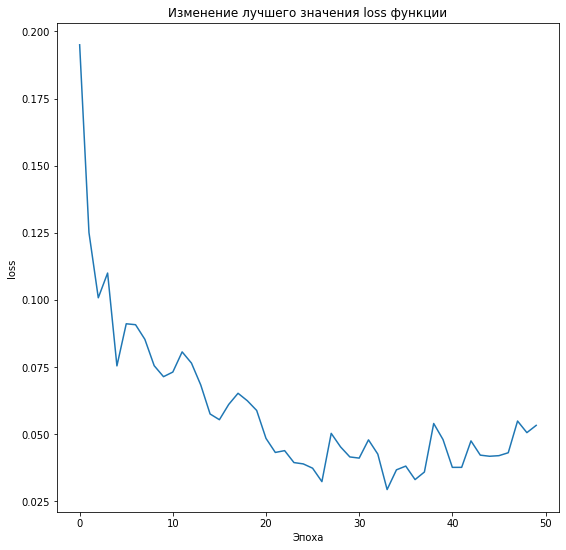

In [46]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(losses_best)
plt.show()

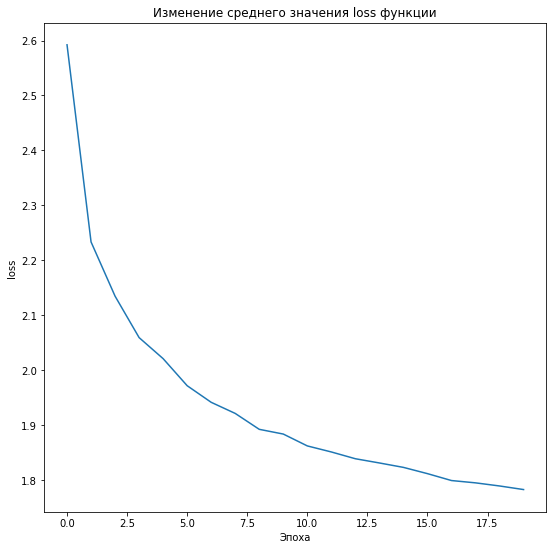

In [172]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(losses_avg)
plt.show()

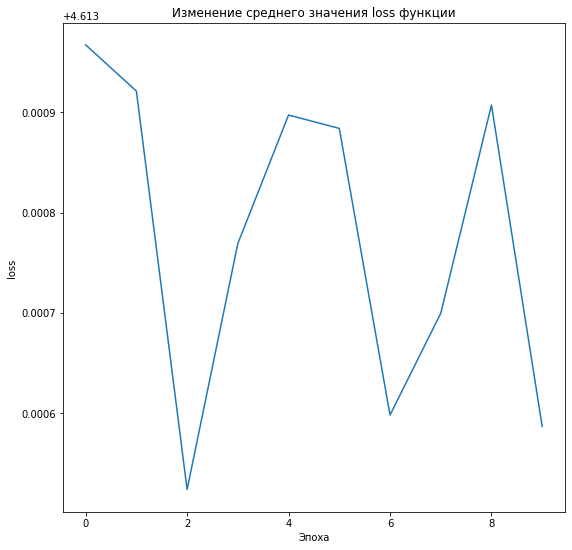

In [210]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(l_avg)
plt.show()

Выведем лучшие значения loss функции, а также эпоху, на которой они были достигнуты.

In [67]:
print("Лучшее значение loss:", min(losses_best),"получено на эпохе:", losses_best.index(min(losses_best)))
print("Лучшее среднее значение loss:", min(losses_avg),"получено на эпохе:", losses_avg.index(min(losses_avg)))

Лучшее значение loss: 0.02929740585386753 получено на эпохе: 33
Лучшее среднее значение loss: 2.5432336 получено на эпохе: 27


Как видно по графикам, обучение дольше 35-ти эпох не принесло особых улучшений, так как средний и лучший (по эпохе) loss остался примерно на том же уровне.

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)